# Analyze event files of intra+inter burst traces

Supplement to the manuscript 'Gating kinetics and pharmacological properties of small conductance calcium-activated potassium channels' by Ilsbeth G.M. van Herck, Vincent Seutin, Bo H. Bentzen, Neil V. Marrion and Andrew G. Edwards <br/>
DOI:

This code analyzes the single SK channel traces that can be included for intra- and inter-burst analysis, individually. Results are presented as text under the corresponding code and stored in a .json file. <br/>

In [47]:
%reset -f

In [48]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib notebook
import scipy.optimize as opt
from scipy.stats import ttest_ind
import math
import json
import csv
import os

In [49]:
output_dir = "patch_analysis"
delim_Q = 1 #s

### Choose patch to analyze from dropdown list

In [50]:
import ipywidgets
dataset_select = ipywidgets.Dropdown(options=['control_1','control_2','control_3','control_4','apamin_1','apamin_2',
                                             'apamin_3','apamin_4','AP14145_1','AP14145_2','AP14145_3'], 
                    description='Dataset')

dataset_select

Dropdown(description='Dataset', options=('control_1', 'control_2', 'control_3', 'control_4', 'apamin_1', 'apam…

In [51]:
dataset = dataset_select.label

##Create output dictionairy
output_dict = {"dataset": dataset}
##Create output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Create a matrix 'times' with the time (relative to experiment start) as the first row. The second row contains 0 if the channel was closed, or -1 if the channel was open at that time. 

In [52]:
# Create array with level for each timepoint
dt = 0.000001 #sec

eventdata = np.loadtxt('data/' + dataset)
times_nonzero = eventdata[:,1]
durations = np.diff(times_nonzero)
levels = eventdata[:,4]

if os.path.isfile('./'+output_dir+'/'+dataset+'_times.npy'):
    times = np.load('./'+output_dir+'/'+dataset+'_times.npy')
    timeframe = np.ceil(times[-1,0])
    print("Loaded 'times' from datafile")
else:
    times_startzero = np.zeros((len(eventdata)))
    times_startzero[:] = times_nonzero - eventdata[0,1] #adjusting to start at 0

    timeframe = np.ceil(times_startzero[-1])
    times = np.zeros((int(timeframe/dt),2))

    try:
        times[:,0] = np.arange(0,timeframe,dt)
    except ValueError:
        times[:,0] = np.arange(0,timeframe-dt,dt)

    j=0
    for i in range(0,len(times)-1):
        if times[i,0] >= times_startzero[j] and times[i,0] < times_startzero[j+1]:
            times[i,1] = [0, levels[j]][levels[j] == -1]
        elif j == len(eventdata)-2:
            break
        else:
            j=j+1

    #save 'times' vector for later use. Saves waiting time, especially for longer experiments. 
    with open('./'+output_dir+'/'+dataset+'_times.npy', 'wb') as f:
        np.save(f, times)

output_dict.update({"dt": dt})

explength = eventdata[-1,1] - eventdata[0,1]
print("Length of total experiment: ", np.round(explength, 2), " sec")

output_dict.update({"exp_duration": explength})

Loaded 'times' from datafile
Length of total experiment:  16.71  sec


In [53]:
##Calculate overall P(o)
nonzeros = np.count_nonzero(times[:,1])
openperc = nonzeros*dt *100 / explength
closedperc = 100-openperc

print("Open probability (Po): {}".format(nonzeros/len(times[:,1])))
print("Channel closed for {} % of time".format(np.around(closedperc, decimals=2)))
print("Percentage time channel open: {} %".format(np.around(openperc, decimals=2)))

output_dict.update({"openProb": nonzeros/len(times[:,1])})
output_dict.update({"channel_closed_perc": closedperc})
output_dict.update({"channel_open_perc": openperc})


Open probability (Po): 0.897101
Channel closed for 8.75 % of time
Percentage time channel open: 91.25 %


In [54]:
#Find number of quiescent events and their start and end times

def zero_runs(a):
    ##Find runs of 0's in an array
    # Create an array that is 1 where a is 0, and pad each end with an extra 0
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

def number_of_closed_periods(a, thresh): #Input is array of arrays from zero_runs()
    ##Find number of closed periods >thresh (ms) in trace 
    Q_runs = np.where(a[:,1] - a[:,0] > thresh)
    return len(Q_runs[0])
    
def get_indices_to_closed_periods(a, thresh): #Input is array of arrays from zero_runs()
    ##Get indices for start and end of closed period >thresh (ms)
    start_idx = []
    end_idx = []
    j=0
    for i,Qrun in enumerate(a):
        if Qrun[1] - Qrun[0] > thresh:
            print("Analyzed period with starting index: ", Qrun[0])
            start_idx.append(Qrun[0])
            end_idx.append(Qrun[1])
    return start_idx, end_idx


runs = zero_runs(times[:,1])
#Define duration Q-periods
Q_threshold = delim_Q/dt
number_Q = number_of_closed_periods(runs, Q_threshold)
startQ_idx, endQ_idx = get_indices_to_closed_periods(runs, Q_threshold)

#time spent in Q-period vs total time
Qdur = 0
for i in range(len(endQ_idx)):
    Qdur = Qdur + (np.array(endQ_idx)[i] - np.array(startQ_idx)[i])
relQdur = Qdur / len(times[:,1])

print("Number of Q-periods: ", number_Q)
print("Starting idx of Q-periods: ", startQ_idx)
print("Ending idx of Q-periods: ", endQ_idx)
print("relative time in Q (%): ", relQdur*100)

output_dict.update({"relative_time_in_Q-periods_perc": relQdur*100})

with open('./'+output_dir+'/' +dataset+ '_results.csv', 'w') as csvf:
    writer = csv.writer(csvf)
    writer.writerow(['starting_idx_Q-periods', startQ_idx])
    writer.writerow(['end_idx_Q-periods', endQ_idx])

Number of Q-periods:  0
Starting idx of Q-periods:  []
Ending idx of Q-periods:  []
relative time in Q (%):  0.0


In [55]:
####Calculate Po and #openings for trace

def calc_openProb(a):
    #Calculate Po for given input data
    openProb = sum(a) * -1 / len(a)
    return openProb
    
def calc_openings(a):
    #Calcualte number of openings for given input data
    return len(np.where(np.diff(a) == -1)[0])
    
    
Po = calc_openProb(times[:,1])
numbO = calc_openings(times[:,1])

print("Po of entire trace = ", Po)
print("Number of openings in entire trace = ", numbO)

#split trace in 500ms periods
segment_len = int(0.5/dt)
num_traceparts = int(len(times[:,0])/(0.5/dt))
Po_parts = []
numbO_parts = []
for i in range(num_traceparts):
    tracepart = times[i*segment_len:(i+1)*segment_len,1]
    Po_parts.append(calc_openProb(tracepart))
    numbO_parts.append(calc_openings(tracepart))

print("Average Po of 500ms segments = ", sum(Po_parts)/len(Po_parts))
print("Average number of openings per 500ms segments = ", sum(numbO_parts)/len(numbO_parts))

#Save results in dict
output_dict.update({"openProb_entire_trace": Po})
output_dict.update({"openings_entire_trace": numbO})
output_dict.update({"openProb_500ms-segments": Po_parts})
output_dict.update({"average_openProb_500ms-segments": sum(Po_parts)/len(Po_parts)})
#output_dict.update({"openings_500ms-segments": numbO_parts})
output_dict.update({"average_openings_500ms-segments": sum(numbO_parts)/len(numbO_parts)})


Po of entire trace =  0.897101
Number of openings in entire trace =  282
Average Po of 500ms segments =  0.8971009999999998
Average number of openings per 500ms segments =  8.294117647058824


In [56]:
###Calculate Po and #openings for 500ms before and after quiescent period
if startQ_idx != []:
    count = 0
    NrQ = np.count_nonzero(startQ_idx)
    Po_before = np.zeros(NrQ)
    Po_after  = np.zeros(NrQ)
    Count_before = np.zeros(NrQ)
    Count_after = np.zeros(NrQ)
    LastOpenBefore = np.zeros(NrQ)
    FirstOpenAfter = np.zeros(NrQ)

    for i in range(0,NrQ):
        start = int(startQ_idx[i])
        end   = int(endQ_idx[i])
        NrT   = int(0.5/dt)
        #Calculate Po in 500 ms before and after quiescence
        #Calculate number of transitions in 500 ms before and after quiescence
        if endQ_idx[i-1] + NrT < start:
            Po_before[count]    = -1* sum(times[(start - NrT): start,1]) / NrT  
            counter = 0
            for j in range(start - NrT,start):
                if times[j,1] == 0 and times[j-1,1] == -1:
                    counter += 1
            Count_before[count] = counter
        else: 
            Po_before[count] = 0

        if i != NrQ-1:
            if end + NrT < startQ_idx[i+1]:    
                Po_after[count]  = -1* sum(times[end: (end + NrT), 1]) / NrT
                counter = 0
                for j in range(end,end+NrT):
                    if times[j,1] == 0 and times[j-1,1] == -1:
                        counter += 1
                Count_after[count] = counter
            else: 
                Po_after[count]  = 0

        #Calculate open duration directly before and after quiescence
        for j in range(1,NrT):
            if times[start-j,1] == 0: 
                LastOpenBefore[count] = j*dt
                break
        for j in range(1,NrT):
            if times[end+j,1] == 0: 
                FirstOpenAfter[count] = j*dt
                break    
        count += 1


    print("Number of quiescent periods: ", count)
    print("{} channel openings in 500ms before quiescence".format(Count_before))
    print("{} channel openings in 500ms after quiescence".format(Count_after))
    print("Last open duration before quiescence (ms): {}".format(LastOpenBefore*1000))
    print("First open duration after quiescence (ms): {}".format(FirstOpenAfter*1000))
    
    ##Save results in dictionairy
    output_dict.update({"number_Q_periods": count})
    output_dict.update({"average_openProb_500ms-segments_beforeQ": sum(Po_before)/len(Po_before)})
    output_dict.update({"average_openProb_500ms-segments_afterQ": sum(Po_after)/len(Po_after)})
    output_dict.update({"average_openings_500ms-segments_beforeQ": sum(Count_before)/len(Count_before)})
    output_dict.update({"average_openings_500ms-segments_afterQ": sum(Count_after)/len(Count_after)})

    ######Save open-dur-around-Q to a csv file
    with open('./'+output_dir+'/' +dataset+ '_results.csv', 'a') as csvf:
        writer = csv.writer(csvf)
        writer.writerow(['openProb_500ms-segments_beforeQ', Po_before])
        writer.writerow(['openProb_500ms-segments_afterQ', Po_after])
        writer.writerow(['openings_500ms-segments_beforeQ', Count_before])
        writer.writerow(['openings_500ms-segments_afterQ', Count_after])
        writer.writerow(['last_open-dur_beforeQ_inms', LastOpenBefore*1000])
        writer.writerow(['first_open-dur_afterQ-inms', FirstOpenAfter*1000])

'con'

In [57]:
##Calculate average Po for all time outside of quiescent periods
# 1s = 1000000 datapoints

if startQ_idx != []:
    PoFornonQ = np.zeros(len(startQ_idx))
    CumLevels_nonQ = 0
    CumTime_nonQ = 0
    NrLongSegments = 0
    PoForLongnonQ = np.zeros(2*len(startQ_idx))
    PoForLongnonQ_250ms = np.zeros(2*len(startQ_idx))
    j = 0
    k = 0
    #Create output file and add info 
    with open("./"+output_dir+"/"+dataset+"_Po_per_500ms_segment.txt", "a+") as f:
        f.write("Each line contains values for the first and last 500ms of a non-Quiescent period that is at least 500ms long. First value is the first 500ms, second value is the last 500ms. \n \nP_o(first);  P_o(last)\n")

    #Take everything between startQ_idx and following endo_idx. These are the times the channel is not in a quiescent period
    for i in range(0,len(startQ_idx)-1):
        print('Length between Q: ', startQ_idx[i+1]-endQ_idx[i])
        CumLevels_nonQ = CumLevels_nonQ + sum(abs(times[int(endQ_idx[i]):int(startQ_idx[i+1]),1]))
        CumTime_nonQ   = CumTime_nonQ   + (int(startQ_idx[i+1])-int(endQ_idx[i]))
        PoFornonQ[i] = sum(abs(times[int(endQ_idx[i]):int(startQ_idx[i+1]),1]))/(startQ_idx[i+1]-endQ_idx[i])

        #Check if non-Q segment is long enough (>500ms) to analyze further
        if (startQ_idx[i+1]-endQ_idx[i]) >= 5.0e5:
            NrLongSegments += 1
            Po_LongnonQ_first = abs(sum(times[int(endQ_idx[i]):int(endQ_idx[i])+int(5.0e5),1])) / 5.0e5
            Po_LongnonQ_last  = abs(sum(times[int(startQ_idx[i+1])-int(5.0e5):int(startQ_idx[i+1]),1])) / 5.0e5
            PoForLongnonQ[j] = Po_LongnonQ_first
            PoForLongnonQ[j+1] = Po_LongnonQ_last
            j += 2

            #Save individual Po's in textfile in case they are needed later. 
            with open("./"+output_dir+"/"+dataset+"_Po_per_500ms_segment.txt", "a+") as f:
                f.write("{}\n{}\n".format(Po_LongnonQ_first, Po_LongnonQ_last))       

            Po_LongnonQ_first_250ms = abs(sum(times[int(endQ_idx[i]):int(endQ_idx[i])+int(2.5e5),1])) / 2.5e5
            Po_LongnonQ_last_250ms  = abs(sum(times[int(startQ_idx[i+1])-int(2.5e5):int(startQ_idx[i+1]),1])) / 2.5e5
            PoForLongnonQ_250ms[k]   = Po_LongnonQ_first_250ms
            PoForLongnonQ_250ms[k+1] = Po_LongnonQ_last_250ms
            k += 2

            #Save individual Po's in textfile in case they are needed later. 
            with open("./"+output_dir+"/"+dataset+"_Po_per_250ms_segment.txt", "a+") as f:
                f.write("{}\n{}\n".format(Po_LongnonQ_first_250ms, Po_LongnonQ_last_250ms))
    TotalPo_nonQ = CumLevels_nonQ / CumTime_nonQ

    print('#segments between Qs:                  ', len(startQ_idx)-1)
    print('Average Po between Q segments:         ', TotalPo_nonQ)
    print('Total time between Q segments (ms):    ', CumTime_nonQ/1.0e3)
    print('#segments between Qs that are >500ms:  ', NrLongSegments)
    print('Average Po in long segments between Q: ', (Po_LongnonQ_first+Po_LongnonQ_last)/2.0)

    ##Save results in dictionary
    output_dict.update({"number_segments_between_Q": len(startQ_idx)-1})
    output_dict.update({"average_Po_nonQ": TotalPo_nonQ})
    output_dict.update({"total_time_nonQ_inms": CumTime_nonQ/1.0e3})
    output_dict.update({"number_segments_>500ms_between_Q": NrLongSegments})
    output_dict.update({"average_Po_>500ms-segments_between_Q": (Po_LongnonQ_first+Po_LongnonQ_last)/2.0})


In [60]:
##Calculate time spent in burst
if dataset[0:3] == "con":
    burst_delim = 31.8*1000 #ms to us
elif dataset[0:3] == "apa":
    burst_delim = 12.3*1000 #ms to us
elif dataset[0:3] == "AP1":
    burst_delim = 87.0*1000 #ms to us
else:
    print("Cannot assign burst delimiter. ")


#find closed durations longer than delim (same as done before for Q)
runs = zero_runs(times[:,1])
number_burst = number_of_closed_periods(runs, burst_delim)
endburst_idx, startburst_idx = get_indices_to_closed_periods(runs, burst_delim)

print("Number of bursts: ", number_burst)
print("Starting idx of bursts: ", startburst_idx)
print("Ending idx of bursts: ", endburst_idx)

output_dict.update({"number_bursts": number_burst})

#Calculate burst duration
idx = 0
if startburst_idx[0] < endburst_idx[0]:
    burstdur = [ele1 - ele2 for (ele1, ele2) in zip(endburst_idx,startburst_idx)]
else: 
    del endburst_idx[0]
    burstdur = [ele1 - ele2 for (ele1, ele2) in zip(endburst_idx,startburst_idx)]

print("Average burst duration (ms): ", sum(burstdur)/len(burstdur)/1000)
output_dict.update({"average_burst_duration": sum(burstdur)/len(burstdur)/1000})

#analyze time spend in burst vs non-burst

if endburst_idx[0] < startburst_idx[0]: #trace starts in burst
    totalburstdur = endburst_idx[0]
    for i in range(len(endburst_idx)-1):
        totalburstdur = totalburstdur + (np.array(endburst_idx)[i+1] - np.array(startburst_idx)[i])
else:
    totalburstdur = 0
    for i in range(len(endburst_idx)):
        totalburstdur = totalburstdur + (np.array(endburst_idx)[i] - np.array(startburst_idx)[i])
relburstdur = totalburstdur / len(times[:,1])
print("Relative time spend in burst (%): ", relburstdur*100)

output_dict.update({"time_in_burst_perc": relburstdur*100})


Analyzed period with starting index:  449875
Analyzed period with starting index:  7992159
Analyzed period with starting index:  8570754
Analyzed period with starting index:  8621859
Analyzed period with starting index:  8873213
Analyzed period with starting index:  12153208
Analyzed period with starting index:  13797397
Analyzed period with starting index:  16711307
Number of bursts:  8
Starting idx of bursts:  [507923, 8043709, 8604162, 8687215, 8913787, 12185914, 13849141, 17000000]
Ending idx of bursts:  [449875, 7992159, 8570754, 8621859, 8873213, 12153208, 13797397, 16711307]
Average burst duration (ms):  2275.4351428571426
Relative time spend in burst (%):  93.69438823529411


In [61]:
## Calculate burst behaviour around quiescent periods
#All Q periods come from a burst (open durations). 
#Interesting thing is to check if there is a difference in burst lenght

#analyze burst duration right before and after Q
if startQ_idx != [] and startburst_idx != []:
    counting = 0
    for i, val in enumerate(startburst_idx):
        for valQ in endQ_idx:
            if abs(valQ - val) < 1:
                counting += 1

    #Extract burst duration before and after each Q-period
    burst_dur_beforeQ = []
    print("startQ: ", startQ_idx)
    print("startB: ", startburst_idx)
    #Skip first Q start if that appears before first burst start
    idx_start = 0
    if startQ_idx[0] < startburst_idx[0]:
        idx_start = 1
        
    for valQ in startQ_idx[idx_start:]: 
        #find idx of same value in endburst_idx
        #find corresponding startburst_idx
        for valB in startburst_idx:
            if valB < valQ:
                temp_burstdur = valQ - valB
        burst_dur_beforeQ.append(temp_burstdur)

    burst_dur_afterQ = []
    for valQ in endQ_idx: 
        found = False
        for valB in endburst_idx:
            if valB > valQ and not found:
                temp_burstdur = valB - valQ
                found = True
        burst_dur_afterQ.append(temp_burstdur)

    output_dict.update({"average_burst_duration_beforeQ": sum(burst_dur_beforeQ)/len(burst_dur_beforeQ)})
    output_dict.update({"average_burst_duration_afterQ": sum(burst_dur_afterQ)/len(burst_dur_afterQ)})
    
    #print("average_burst_duration_beforeQ: ", sum(burst_dur_beforeQ)/len(burst_dur_beforeQ))
    #print("average_burst_duration_afterQ: ", sum(burst_dur_afterQ)/len(burst_dur_afterQ))

    with open('./'+output_dir+'/' +dataset+ '_results.csv', 'a') as csvf:
        writer = csv.writer(csvf)
        writer.writerow(['burst_duration_beforeQ', burst_dur_beforeQ])
        writer.writerow(['burst_duration_afterQ', burst_dur_afterQ])

## Analyze flickery activity

In [63]:
  
##Find where there is a range of very short open and closed durations

eventswitches = eventdata[:,1]
eventdiffs = np.diff(eventswitches)
count_flickery = 0
prev_count = 0
flickery_dur = 0
for i in range(len(eventdiffs)-10): 
    if np.all(eventdiffs[i:i+10] < 0.005) and (np.all(eventdiffs[i:2:i+10] < 0.001) or np.all(eventdiffs[i+1:2:i+10] < 0.001)):
        #opendurs < 1ms AND closeddurs < 5ms
        #Count number and length of this happening
        flickery_dur += eventdiffs[i]
        if i != prev_count + 1:
            #start of flickery period
            count_flickery += 1
        prev_count = i
    else:
        #next 10 durations are flickery, add to duration
        if i != 1 and i == prev_count +1:
            flickery_dur += sum(eventdiffs[i:i+10])

print("Number of flickery activity ", count_flickery)
print("flickery_dur ", flickery_dur)
print("flickery dur / exp_length (%): ", flickery_dur*100/explength)

output_dict.update({"number_flickery_periods>10x": count_flickery})
output_dict.update({"flickery_duration_>10x_ms": flickery_dur})
output_dict.update({"flickery_dur_per_explength_>10x_perc": flickery_dur*100/explength})

count_flickery = 0
prev_count = 0
flickery_dur = 0
for i in range(len(eventdiffs)-20): 
    if np.all(eventdiffs[i:i+20] < 0.005) and (np.all(eventdiffs[i:2:i+20] < 0.001) or np.all(eventdiffs[i+1:2:i+20] < 0.001)):
        #opendurs < 1ms AND closeddurs < 5ms
        #Count number and length of this happening
        flickery_dur += eventdiffs[i]
        if i != prev_count + 1:
            #start of flickery period
            count_flickery += 1
        prev_count = i
    else:
        #next 20 durations are flickery, add to duration
        if i != 1 and i == prev_count +1:
            flickery_dur += sum(eventdiffs[i:i+20])

print("Number of flickery activity ", count_flickery)
print("flickery_dur ", flickery_dur)
print("flickery dur / exp_length (%): ", flickery_dur*100/explength)


output_dict.update({"number_flickery_periods>20x": count_flickery})
output_dict.update({"flickery_duration_>20x_ms": flickery_dur})
output_dict.update({"flickery_dur_per_explength_>20x_perc": flickery_dur*100/explength})


Number of flickery activity  0
flickery_dur  0
flickery dur / exp_length (%):  0.0
Number of flickery activity  0
flickery_dur  0
flickery dur / exp_length (%):  0.0


In [64]:
##Save dictionairy to json file
print(output_dict)
with open('./'+output_dir+'/' +dataset+ '_results.json', 'w') as jf:
    json.dump(output_dict, jf, indent=4)

{'dataset': 'control_1', 'dt': 1e-06, 'exp_duration': 16.712853789999997, 'openProb': 0.897101, 'channel_closed_perc': 8.748576445243927, 'channel_open_perc': 91.25142355475607, 'relative_time_in_Q-periods_perc': 0.0, 'openProb_entire_trace': 0.897101, 'openings_entire_trace': 282, 'openProb_500ms-segments': [0.87542, 0.968772, 0.943466, 0.919586, 0.888648, 0.8906, 0.938762, 0.940354, 0.919678, 0.991038, 0.98296, 0.953494, 0.974254, 0.913294, 0.934188, 0.80824, 0.862788, 0.56765, 0.935024, 0.92687, 0.919896, 0.94313, 0.893218, 0.95143, 0.892346, 0.929122, 0.95359, 0.780858, 0.932418, 0.971314, 0.965608, 0.922366, 0.89928, 0.411772], 'average_openProb_500ms-segments': 0.8971009999999998, 'average_openings_500ms-segments': 8.294117647058824, 'number_bursts': 8, 'average_burst_duration': 2275.4351428571426, 'time_in_burst_perc': 93.69438823529411, 'number_flickery_periods>10x': 0, 'flickery_duration_>10x_ms': 0, 'flickery_dur_per_explength_>10x_perc': 0.0, 'number_flickery_periods>20x': 0

<IPython.core.display.Javascript object>


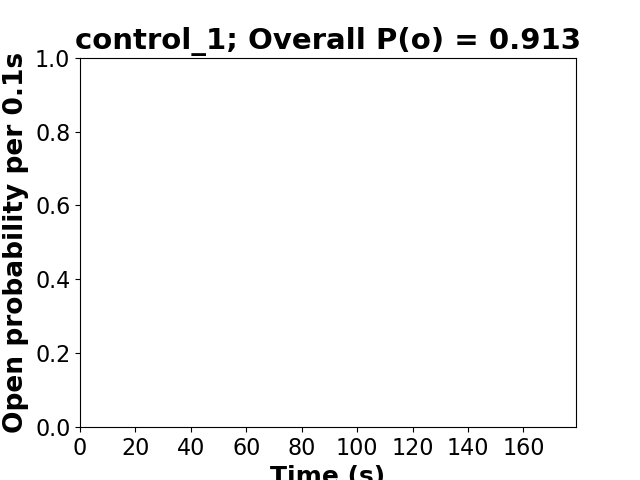

<IPython.core.display.Javascript object>


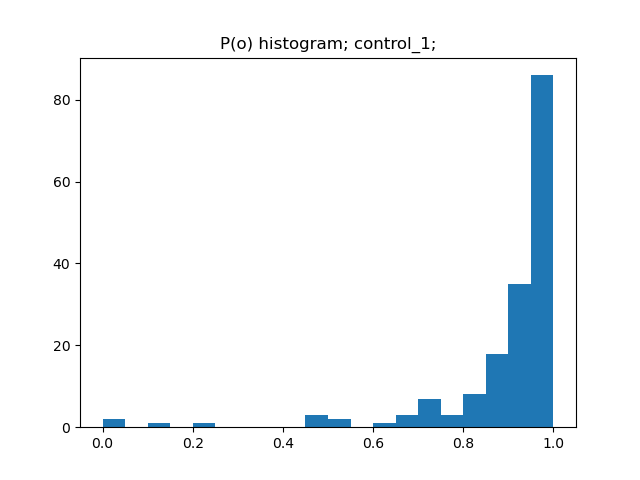

(170,)


<IPython.core.display.Javascript object>


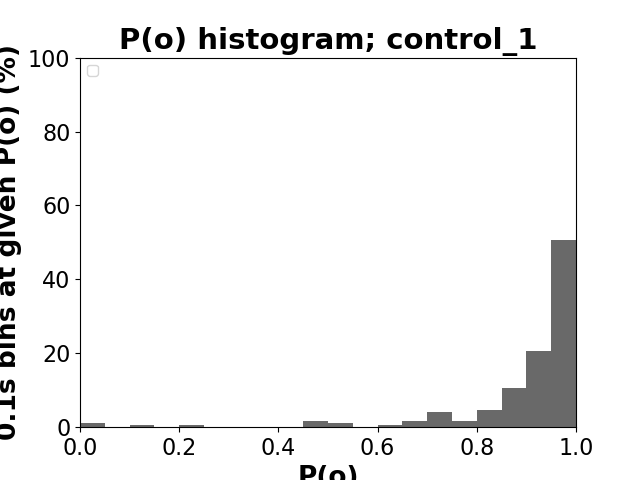

No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>


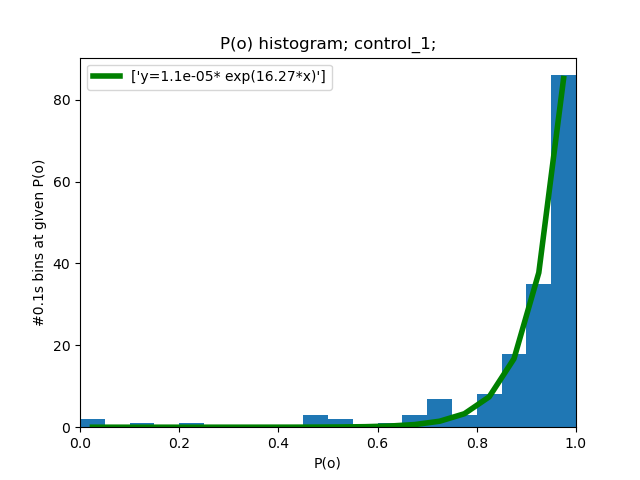

In [76]:
##plotting
plotting = True
binsize = 0.1 #sec
nrbins = math.floor(np.ceil(times[-1,0])/binsize)
if plotting: 
    ##Plot1: P(o)
    maxlen=len(times)/nrbins
    totPo=((-times[:,1].sum(axis=0))*dt)/explength

    SOL = np.reshape(times[0:int((np.floor(maxlen)*nrbins)),1],(int(nrbins),-1))
    binPo = (-SOL.sum(axis=1))*dt /binsize

    plt.figure()
    try:
        plt.bar(np.arange(0,timeframe,binsize), binPo, align = 'edge', width = binsize, ls = 'solid', lw = 1, facecolor = 'none')
    except ValueError:
        plt.bar(np.arange(0,timeframe-binsize,binsize), binPo, align = 'edge', width = binsize, ls = 'solid', lw = 1, facecolor = 'none')
    plt.ylabel('Open probability per {}s'.format(binsize), fontsize=19, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=18, fontweight='bold')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(0,1)
    plt.xlim(0,179)
    plt.title('{}; Overall P(o) = {}' .format(dataset, np.round(totPo,3)), fontsize=21, fontweight='bold')
    plt.show()

    plt.savefig(str(output_dir)+'/' + str(dataset) + '-Diary.eps')

    
    ##Plot2: histogram of P(o) values
    plt.figure()
    print(np.shape(binPo))
    plt.title('P(o) histogram; {};' .format(dataset))
    histPo = plt.hist(binPo, bins=(0.00,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1.0)) #Plot histogram with set edges (10bins)
    histPo_y = histPo[0]
    histPo_x = [np.around((histPo[1][i]+histPo[1][i+1])/2 ,decimals=3) for i in range(0,20)]
    #histPo_fit = opt.curve_fit(lambda t,a,b: a*np.exp(b*t), histPo_x, histPo_y)
    #histPo_opt = [histPo_fit[0][0] * np.exp(histPo_fit[0][1]*histPo_x[i])for i in range(0,len(histPo_x))]
    plt.figure()
    plt.title('P(o) histogram; {}'.format(dataset), fontsize=21, fontweight='bold')
    plt.bar(histPo_x, histPo_y*100/sum(histPo_y), width=0.05, align='center',color='dimgray')

    plt.xlabel("P(o)", fontsize=19, fontweight='bold')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim([0.0, 1.0])
    plt.ylabel(str(binsize) + "s bins at given P(o) (%)", fontsize=19, fontweight='bold')
    plt.legend(loc=2)
    plt.ylim([0,100])
    plt.show()

    plt.savefig(str(output_dir)+'/' + str(dataset) + '_PoHist.eps')

    
    ##Plot3: histogram of P(o) values - normalized
    plt.figure()
    plt.title('P(o) histogram; {};' .format(dataset))
    histPo = plt.hist(binPo, bins=(0.00,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1.0)) #, normed=True) #Plot histogram with set edges (10bins)
    histPo_y = histPo[0]
    histPo_x = [np.around((histPo[1][i]+histPo[1][i+1])/2 ,decimals=3) for i in range(0,20)]
    histPo_fit = opt.curve_fit(lambda t,a,b: a*np.exp(b*t), histPo_x, histPo_y)
    histPo_opt = [histPo_fit[0][0] * np.exp(histPo_fit[0][1]*histPo_x[i])for i in range(0,len(histPo_x))]
    plt.plot(histPo_x, histPo_opt, '-g',linewidth=4, label=['y=' + str(np.around(histPo_fit[0][0],decimals=6)) + '* exp(' + str(np.around(histPo_fit[0][1],decimals=2)) + '*x)'])

    plt.xlabel("P(o)")
    plt.xlim([0.0, 1.0])
    plt.ylabel("#" + str(binsize) + "s bins at given P(o)")
    plt.legend(loc=2)
    plt.show()
    
    

In [ ]:

    ##Plot4: accumulative plots
    del binPo
    ###Import seperate binPo's and plot them together in a normalized histogram
    datalist = ["control_1", "control_3", "control_3"] # Control
    #datalist = ["apamin_1", "apamin_2", "apamin_3"] #Apamin
    #datalist = ["AP14145_1", "AP14145_2", "AP14145_3"] #AP14145

    for filename in datalist:
        if filename == "control_1" or filename == "apamin_1" or filename == "AP14145_1":
            binPo = np.load('./data/' + str(filename) + '_binPo.npy')
            histPo = plt.hist(binPo, bins=(0.00,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1.0)) #Plot histogram with set edges (10bins)
            print('In bin1: {}'.format(histPo[0][0]))
            print('In rest: {}'.format(sum(histPo[0])-histPo[0][0]))
        else:
            tempPo = np.load('./data/' + str(filename) + '_binPo.npy')
            histPo = plt.hist(tempPo, bins=(0.00,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1.0)) #Plot histogram with set edges (10bins)
            print('In bin1: {}'.format(histPo[0][0]))
            print('In rest: {}'.format(sum(histPo[0])-histPo[0][0]))
            binPo = np.append(binPo, tempPo)
    
    plt.figure()
    print(np.shape(binPo))
    plt.title('P(o) histogram')
    histPo = plt.hist(binPo, bins=(0.00,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1.0)) #Plot histogram with set edges (10bins)
    histPo_y = histPo[0]
    histPo_x = [np.around((histPo[1][i]+histPo[1][i+1])/2 ,decimals=3) for i in range(0,20)]
    plt.figure()
    plt.title('Cumulative P(o) histogram; Control', fontsize=21, fontweight='bold')
    plt.barh(histPo_x, histPo_y*100/sum(histPo_y), height=0.05, align='center',color='dimgray')

    plt.ylabel("P(o)", fontsize=19, fontweight='bold')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim([0.0, 1.0])
    plt.xlabel(str(binsize) + "s bins at given P(o) (%)", fontsize=19, fontweight='bold')
    plt.legend(loc=2)
    plt.xlim([0,100])
    plt.show()

    plt.savefig('./'+output_dir+'/PoHist_Control_hor.eps')